In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyvo as vo

from astropy.table import Table

In [2]:
cd ../../gaia-wide-binaries/notebooks/Bensby13

/Users/semyeong/projects/gaia-wide-binaries/notebooks/Bensby13


In [3]:
ls

ReadMe                 tablec1.dat            targetlist_bensby.txt
findingcharts/         tablec2.dat
simbad.xml             tablec3.dat


In [4]:
cat ReadMe

J/A+A/562/A71  Chemical abundances of solar neighbourhood dwarfs (Bensby+, 2014)
Exploring the Milky Way stellar disk. A detailed elemental abundance study of
714 F and G dwarf stars in the solar neighbourhood.
    Bensby T., Feltzing S., Oey M.S.
   <Astron. Astrophys. 562, A71 (2014)>
   =2014A&A...562A..71B
ADC_Keywords: Abundances ; Spectroscopy ; Stars, ages ; Stars, dwarfs ;
              Stars, nearby
Keywords: Galaxy: disk - Galaxy: formation - Galaxy: evolution -
          stars: abundances - stars: fundamental parameters -
          stars: kinematics and dynamics

Abstract:
    We present a detailed elemental abundance study of 714 F and G dwarf
    and subgiant stars in the Solar neighbourhood. The analysis is based
    on high-resolution spectra obtained with MIKE on the Magellan
    telescope, FEROS on the ESO 1.5m and 2.2m telescopes, HARPS on the
    ESO 3.6m telescope, UVES on the ESO Very Large Telescope, SOFIN and
    FIES on the Nordic Optical Telescope. Our data sho

In [14]:
t3 = Table.read("tablec3.dat", format='ascii.cds', readme='ReadMe')

In [6]:
t3[['HIP', 'Ulsr', 'Vlsr', 'Wlsr']][:3]

HIP,Ulsr,Vlsr,Wlsr
,km / s,km / s,km / s
int64,int64,int64,int64
80,-102,-80,-18
305,-10,-3,25
407,11,-13,10


In [3]:
tap = vo.dal.TAPService("http://simbad.u-strasbg.fr/simbad/sim-tap")

In [57]:
iden = Table()
iden['hip'] = ['HIP{:>7d}'.format(hip).encode('utf-8') for hip in t3['HIP']]
iden.write("tmp.xml", format='votable', overwrite='True')

In [60]:
query = """
select t1.hip, bibcode, nbmes, obsdate, qual, quality, velType, velValue, velValue_prec, remark, remarks, id1.oidref
from TAP_UPLOAD.t1 as t1 left join ident as id1 on id1.id=t1.hip
left join mesVelocities as v on v.oidref = id1.oidref
"""

result = tap.run_sync(query, uploads={'t1': ('inline', 'tmp.xml')})

In [62]:
dfbensbyrv = result.table.to_pandas()

In [64]:
# decode all bytestrings
dfbensbyrv = dfbensbyrv.apply(lambda x: x.str.decode('utf-8') if x.dtype==object else x)

In [70]:
dfbensbyrv.oidref = dfbensbyrv.oidref.astype('int')

In [82]:
dfbensbyrv['hipnospace'] = [s.replace(' ', '') for s in dfbensbyrv.hip]

In [84]:
dfbensbyrv.to_csv("bensbyrv.csv", index=False)

In [72]:
dfident = pd.read_csv("../../../GaiaPairsFollowup/data/star_identifier.csv")

In [74]:
dfobs = pd.read_csv("../../../GaiaPairsFollowup/data/observed.csv")

In [114]:
calibstar = dfobs.groupby("objtype").get_group("calibstar")

In [115]:
calibstar = calibstar.loc[calibstar.OBJECT.apply(lambda x:x[:3]=='HIP'), ['OBJECT']]

In [116]:
len(calibstar)

95

In [117]:
calibstarrv = pd.merge(calibstar, dfbensbyrv, left_on='OBJECT', right_on='hipnospace')

In [118]:
calibstarrv.OBJECT.unique().size

77

In [119]:
gobj = calibstarrv.groupby('OBJECT')

In [132]:
gobj.std().velValue.values

array([  5.65803242e+00,   9.29805140e-01,   1.25069113e+00,
         9.40817656e-01,   1.25830675e-01,   1.21975331e+00,
         7.84750562e-01,   2.20241648e-07,   1.50536817e-01,
         1.16057064e+00,   1.63111010e+00,   6.06257255e-01,
         2.68760813e-01,   3.23687797e-07,   5.98914530e+00,
         1.55884705e-01,   3.23008556e+00,   7.07109479e-02,
         1.03473026e+00,   3.28070521e+00,   3.40060190e-01,
                    nan,   4.88149919e+01,   2.33858737e-01,
         2.10412988e+00,   1.10189250e+00,   3.76144301e-01,
         3.00000127e-01,   2.08092001e+00,   2.12132034e-01,
         1.88038105e+00,   1.09546183e-01,   2.25167134e-01,
         2.38500206e+00,   3.24891694e+00,   2.30940053e-01,
         1.47266315e+00,   3.14655890e-01,   2.24854935e+00,
         1.38700115e+00,   1.96298915e-01,   2.19202563e-01,
         1.93300489e+00,   1.75011418e+00,   1.10560322e-01,
         3.37971892e+00,   9.24348086e-02,   2.94561821e-01,
         4.91350059e-01,

In [148]:
len(gobj)

77

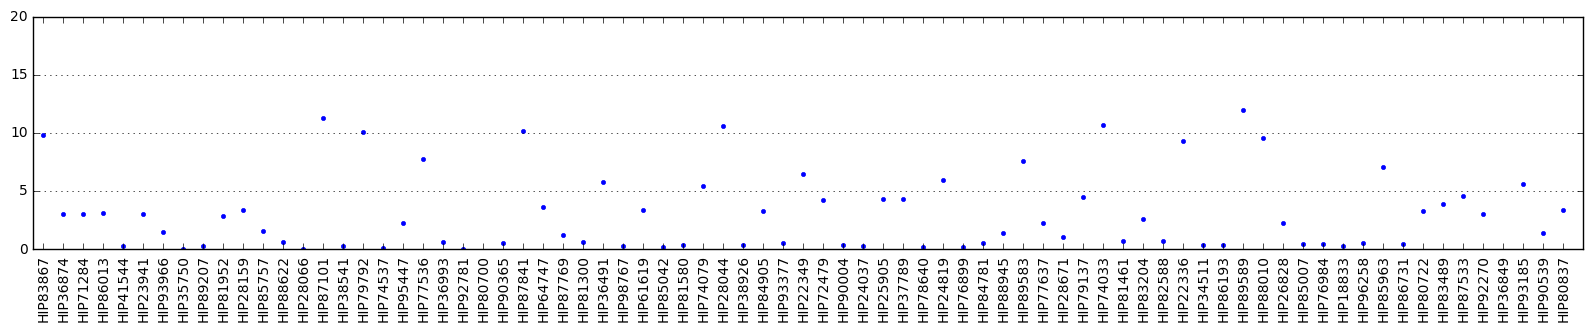

In [154]:
plt.figure(figsize=(20,3))
plt.plot(gobj.velValue.agg(lambda x: x.max()-x.min()).values, '.');
plt.xticks(np.arange(len(gobj)), list(gobj.groups.keys()), rotation=90);
plt.ylim(0,20);
plt.xlim(-0.5, len(gobj));
plt.grid(axis='y');

In [159]:
g = gobj.get_group('HIP83867')

In [160]:
g

,bibcode,hip,hipnospace,nbmes,obsdate,oidref,qual,quality,remark,remarks,velType,velValue,velValue_prec
235,2013A&A...552A..64S,HIP 83867,HIP83867,NaN,NaN,2580459,,A,,,z,-52.079000,3.0
236,2006AstL...32..759G,HIP 83867,HIP83867,NaN,NaN,2580459,,A,,,V,-51.900000,2.0
237,2004A&A...418..989N,HIP 83867,HIP83867,4.0,NaN,2580459,,A,,,v,-51.900002,1.0
238,2013A&A...552A..64S,HIP 83867,HIP83867,NaN,NaN,2580459,,A,,,z,-52.079000,3.0
239,2006AstL...32..759G,HIP 83867,HIP83867,NaN,NaN,2580459,,A,,,V,-51.900000,2.0
240,2004A&A...418..989N,HIP 83867,HIP83867,4.0,NaN,2580459,,A,,,v,-51.900002,1.0


In [172]:
g.sort_values(by=['quality', 'velValue_prec'], ascending=[True, False]).iloc[0]

bibcode          2013A&A...552A..64S
hip                       HIP  83867
hipnospace                  HIP83867
nbmes                            NaN
obsdate                          NaN
oidref                       2580459
qual                                
quality                            A
remark                              
remarks                             
velType                          z  
velValue                     -52.079
velValue_prec                      3
Name: 235, dtype: object

In [198]:
# select value with highest precision
rows = []
for iden, g in gobj:
    gsorted = g.sort_values(by=['velValue_prec'])
    gsorted = gsorted.loc[~gsorted.velValue_prec.isnull()]
    if len(gsorted) == 0:
        print("{:s} has nothing left".format(iden))
    rows.append(gsorted.iloc[-1])
dfbensbyrv_unique = pd.DataFrame(rows)

In [199]:
dfbensbyrv_unique.bibcode.unique()

array(['2007A&A...475..519H', '2002ApJS..141..503N', '2002AJ....124.1144L',
       '17AJ....153...7521K', '2006AstL...32..759G', '2010A&A...521A..12M',
       '2013A&A...552A..64S', '2011AAS...21743412C', '2008AJ....135..209M',
       '2011A&A...526A.112S', '2010A&A...511L..10N', '2011A&A...527A..63M',
       '2012MNRAS.422...14H', '2004A&A...424..727P', '2015A&A...574A..50J'], dtype=object)

In [202]:
dfbensbyrv_unique.to_csv("bensbyrv_bestunique.csv", index=False)

In [203]:
!wc -l bensbyrv*.csv

    3149 bensbyrv.csv
      78 bensbyrv_bestunique.csv
    3227 total


In [40]:
tap.run_sync("select * from TAP_SCHEMA.tables where schema_name not like 'TAP_SCHEMA'").table[['table_name', 'description']].write("tables.txt", format='ascii')

In [24]:
def pprint_columns_description(tablename):
    """Pretty print column description table"""
    rows = []
    for col in tap.run_sync(
        "select top 0 * from {}".format(tablename)).table.itercols():
        rows.append([col.name, col.dtype.str, col.description])
    tt = Table(rows=rows, names=['colname', 'dtype','description'])
    return tt